In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter("ignore", UserWarning)

import statsmodels.api as sm
SARIMAX = sm.tsa.statespace.SARIMAX
from sklearn.ensemble import RandomForestRegressor

## Preprocesado

In [1]:
from google.colab import files
uploaded = files.upload()

Saving DATOS_ventas conjuntos.xlsx to DATOS_ventas conjuntos.xlsx


In [3]:
# Cargar datos a DataFrame
df_raw = pd.read_excel('DATOS_ventas conjuntos.xlsx')
df_raw.head()

ZONE   NON DEALER                DEALER_NAME ORDER_NO VIN_PREFIX  \
0   N3  P5ZZ  11960   VEDAT MEDITERRANEO, S.L.     CAGE     WF0FXX   
1   N2  P6T4  10610  COMERCIAL VILA-VILA, S.A.     CAAK     WF0FXX   
2   N3  P76P  11960   VEDAT MEDITERRANEO, S.L.     CAGD     WF0FXX   
3   N2  Q477  10980    AUTOMOCIO 2000 BCN,S.A.     CACU     WF0UXX   
4   N2  Q47B  10980    AUTOMOCIO 2000 BCN,S.A.     CACV     WF0UXX   

           VIN          Bastidor                      MODEL        BODY  ...  \
0  WPMFLA12753  WF0FXXWPMFLA12753                KUGA CX482   5 PUERTAS  ...   
1  WPMHLA22025  WF0FXXWPMHLA22025                KUGA CX482   5 PUERTAS  ...   
2  WPMFLA37417  WF0FXXWPMFLA37417                KUGA CX482   5 PUERTAS  ...   
3  WPGULA30312  WF0UXXWPGULA30312  V408 TOURNEO CONNECT MCA  TOURNEO L2  ...   
4  WPGULA30258  WF0UXXWPGULA30258  V408 TOURNEO CONNECT MCA  TOURNEO L2  ...   

  MARKETING_CODE_2 MARKETING_CODE_3 MARKETING_CODE_4 MARKETING_CODE_5  \
0            AMIGO              NaN              NaN              NaN   
1            POLF3              NaN              NaN              NaN   
2            CONMO            AMIGO              NaN              NaN   
3              NaN              NaN              NaN              NaN   
4              NaN              NaN              NaN              NaN   

  FLEET_ID_NUMBER LEASE_NO           INV__DATE SELL_DLR_CD  \
0             NaN      NaN 2020-03-12 23:58:00       1196K   
1           BP254    BO083 2020-03-10 23:58:00       10610   
2             NaN      NaN 2020-05-14 23:58:00       1196N   
3           DO290    DO290 2020-03-05 23:58:00       10980   
4           DO290      NaN 2020-03-05 23:58:00       10980   

                                       SPECIFICATION        HIBRIDOS  
0  00J YYU MTF MU8 NN9 NW4 NXB NYA NZ4 OON TDA TD...             NaN  
1  00J YYU MTF MU8 NN9 NWA NXZ NYE NZ3 OFR OON TD...  Plug-in Hybrid  
2  00J YYU MTF MUY NN9 NWS NX1 NYU NZC OON OOS TD...             NaN  
3  00Q YYT UHU UPZ UQ9 UMJ UR3 USU UTQ Z16 Z5K Z7...             NaN  
4  00Q YYT UHU UPZ UQ9 UMJ UR3 USU UTQ Z16 Z5K Z7...             NaN  

[5 rows x 45 columns]

In [4]:
# Seleccionar columnas
df = df_raw[['ZONE', 'DEALER', 'VEHICLE_CATEGORY', 'RETAIL_DATE', 'Canal', 'HIBRIDOS']]

# Renombrar columnas
df.columns = ['Zone', 'Dealer', 'Vehicle_category', 'Date', 'Channel', 'Hybrid']

df.head()

Zone Dealer Vehicle_category       Date Channel          Hybrid
0   N3  11960              Car 2020-05-14  RETAIL             NaN
1   N2  10610              Car 2020-06-08   FLEET  Plug-in Hybrid
2   N3  11960              Car 2020-06-15  RETAIL             NaN
3   N2  10980              Car 2020-06-11   FLEET             NaN
4   N2  10980              Car 2020-06-11   FLEET             NaN

In [5]:
# Encontrar valores faltantes
df.isna().sum()

Zone                    0
Dealer                  0
Vehicle_category        0
Date                    0
Channel                 0
Hybrid              88326
dtype: int64

In [6]:
# Solo hay este tipo valores en Hybrid porque los motores de combustión interma aparecen como NaN
# Agrupamos los motores híbridos (los que no son nan) en una sola nueva categoria "Progressive" y luego reemplazamos NaN por "Traditional" para los motores de combustión interna
df.loc[~df['Hybrid'].isnull(), 'Hybrid'] = 'Progressive'
df.loc[df['Hybrid'].isnull(), 'Hybrid'] = 'Traditional'

In [7]:
# Comprobar valores únicos de las predictoras
for col in df.columns:
    if col != 'Date':
        print(col + ':', df[col].unique(), sep='\n')

Zone:
['N3' 'N2' 'N5' 'N1' 'N4' 'N6' 'N7' 'Z2' 'Z1']
Dealer:
[11960 10610 10980 18890 11730 18570 11910 15350 18610 16560 12590 11350
 '1A820' 11680 13070 16860 12100 12660 18860 18990 14100 15740 11110 10640
 18200 14330 16760 11790 13000 12820 12830 11120 18680 15220 12710 10700
 11200 12680 17110 '1A870' 18800 11690 14590 12140 18830 12350 12450 16000
 10450 18180 10590 15860 10550 14410 15550 15000 10010 18140 12340 16410
 11150 13330 10250 11170 11000 15100 17430 16500 '1A840' 11830 12650 16600
 11310 16820 18410 11370 '8DE10' '8LE10' '8DN00' '8DR00' 11980 '8DS00'
 18250 '8LE00' '1A830' '8DS10' '8DM10' '8DP10' 16010 '8DV00' '8DN10'
 '8DT00' '8DF00' '7B000' '8DV10' 15360 '7H003' '11730' '10610' '11350'
 '10700' '10980' '18610' '17430' '12660' '16410' '11830' '12350' '10590'
 '16600' '16860' '10640' '14410' '11150' '10450' '12710' '14330' '11170'
 '18860' '11980' '11200' '11960' '12820' '18830' '16760' '18180' '14100'
 '18890' '15740' '18140' '10550' '12450' '11120' '10250' '10010' 

In [8]:
# Eliminamos la variable Dealer porque tiene demasiados valores únicos e introducirá demasiado ruido
df.drop('Dealer', axis=1, inplace=True)

<ipython-input-8-280d2c7d9562>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('Dealer', axis=1, inplace=True)


In [9]:
# Comprobar rango de fechas
print('Fecha mínima: ', df.Date.min(), '\n', 'Fecha máxima: ', df.Date.max(), sep='')

Fecha mínima: 2020-01-02 00:00:00
Fecha máxima: 2022-12-29 00:00:00


In [10]:
# Convertir columna Date de formato datetime a formato mes
df['Date'] = pd.to_datetime(df.loc[:, 'Date']).dt.to_period('M')
df['Date']

<ipython-input-10-31d440075d84>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df.loc[:, 'Date']).dt.to_period('M')


0         2020-05
1         2020-06
2         2020-06
3         2020-06
4         2020-06
           ...   
141301    2022-11
141302    2022-11
141303    2022-11
141304    2022-11
141305    2022-11
Name: Date, Length: 141306, dtype: period[M]

In [11]:
df.head()

Zone Vehicle_category     Date Channel       Hybrid
0   N3              Car  2020-05  RETAIL  Traditional
1   N2              Car  2020-06   FLEET  Progressive
2   N3              Car  2020-06  RETAIL  Traditional
3   N2              Car  2020-06   FLEET  Traditional
4   N2              Car  2020-06   FLEET  Traditional

## Modelo SARIMA

In [12]:
# Partir en datos de entrenamiento y validación por fecha
# Seleccionamos la segunda mitad del año 2022 como datos de validación
splitting_date = '2022-07'
train_df_t = df[(df['Date'] < splitting_date) & (df['Hybrid'] == 'Traditional')].groupby(['Date'])['Hybrid'].count()
test_df_t = df[(df['Date'] >= splitting_date) & (df['Hybrid'] == 'Traditional')].groupby(['Date'])['Hybrid'].count()
train_df_p = df[(df['Date'] < splitting_date) & (df['Hybrid'] == 'Progressive')].groupby(['Date'])['Hybrid'].count()
test_df_p = df[(df['Date'] >= splitting_date) & (df['Hybrid'] == 'Progressive')].groupby(['Date'])['Hybrid'].count()

# Comprobamos los tamaños de los conjuntos
print('Training size (Traditional):', train_df_t.sum(), 'vehicles')
print('Test size (Traditional): ', test_df_t.sum(), 'vehicles')
print('Training size (Progressive):', train_df_p.sum(), 'vehicles')
print('Test size (Progressive): ', test_df_p.sum(), 'vehicles')

Training size (Traditional): 74199 vehicles
Test size (Traditional):  14127 vehicles
Training size (Progressive): 46015 vehicles
Test size (Progressive):  6965 vehicles


In [13]:
# Función para obtener AIC para un conjunto de parámetros dado (la usaremos para optimizar)
def get_aic(params, train_data):
    try:
        model = SARIMAX(train_data, order=params[:3], seasonal_order=params[3:])
        results = model.fit(maxiter=200, method='powell', disp=False)
        return results.aic
    except:
        return None

# Función para obtener predicciones y RMSE para un conjunto de parámetros dado
def sarima_forecast(train_data, test_data, params):
    model = SARIMAX(train_data, order=params[:3], seasonal_order=params[3:])
    results = model.fit(maxiter=200, method='powell', disp=False)
    forecast_data = results.get_forecast(steps=len(test_data))
    forecast_mean = forecast_data.predicted_mean
    rmse = mean_squared_error(test_data, forecast_mean) ** 0.5
    return forecast_mean, rmse

In [14]:
# Lista de parámetros a probar
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
P = range(0, 2)
D = range(0, 2)
Q = range(0, 2)

# Creamos diccionarios para guardar los resultados
results = {'Traditional': dict(), 'Progressive': dict()}

print('Obtaining hyperparameters for Traditional motor...')
params_list = product(p, d, q, P, D, Q, [12])
for params in params_list:
    key = str(params)
    aic = get_aic(params, train_df_t)
    if aic is not None:
        results['Traditional'][key] = aic

print('Obtaining hyperparameters for Progressive motor...')
params_list = product(p, d, q, P, D, Q, [12])
for params in params_list:
    key = str(params)
    aic = get_aic(params, train_df_p)
    if aic is not None:
        results['Progressive'][key] = aic

# Filtramos los resultados para quedarnos con los mejores parámetros
best_params = {model: eval(min(results[model], key=results[model].get)) for model in results.keys()}
print('Best parameters:', best_params)

Obtaining hyperparameters for Traditional motor...
Obtaining hyperparameters for Progressive motor...
Best parameters: {'Traditional': (2, 1, 1, 1, 1, 0, 12), 'Progressive': (0, 1, 0, 1, 1, 0, 12)}


In [15]:
# Ajustar modelo con los mejores parámetros y predecir para los datos de validación
forecast_dict = {}

print('Forecasting Traditional motor...')
forecast_mean, rmse = sarima_forecast(train_df_t, test_df_t, best_params['Traditional'])
forecast_dict['Traditional'] = (forecast_mean, rmse)
print('Traditional forecast:\n', forecast_mean, sep='')
print('Traditional RMSE: ', rmse, sep='')

print()

print('Forecasting Progressive motor...')
forecast_mean, rmse = sarima_forecast(train_df_p, test_df_p, best_params['Progressive'])
forecast_dict['Progressive'] = (forecast_mean, rmse)
print('Progressive forecast:\n', forecast_mean, sep='')
print('Progressive RMSE: ', rmse, sep='')

Forecasting Traditional motor...
Traditional forecast:
2022-07    3973.995115
2022-08    1889.849415
2022-09    3295.426303
2022-10    3556.387106
2022-11    2598.554786
2022-12    1954.544862
Freq: M, Name: predicted_mean, dtype: float64
Traditional RMSE: 770.4197524377728

Forecasting Progressive motor...
Progressive forecast:
2022-07    1663.747759
2022-08    1215.046927
2022-09    1935.008323
2022-10    2160.719625
2022-11    2119.477478
2022-12    3024.156297
Freq: M, Name: predicted_mean, dtype: float64
Progressive RMSE: 1013.8753588298121


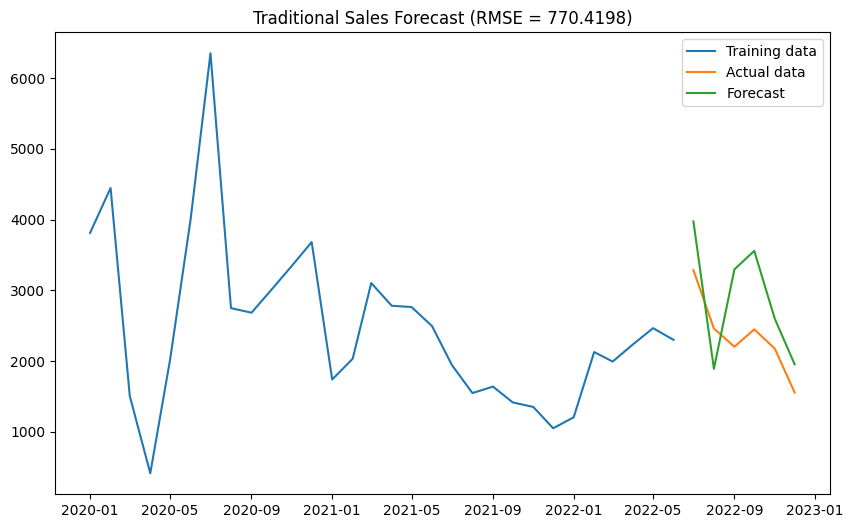

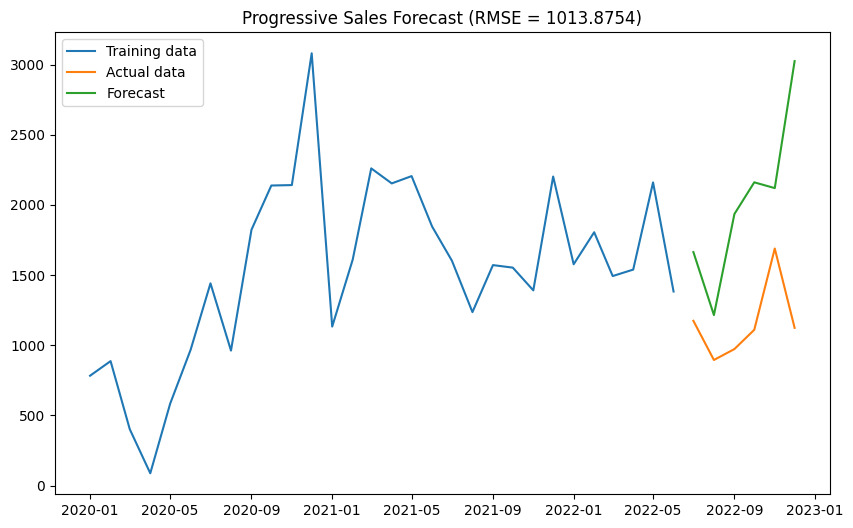

In [16]:
# Mostramos resultados
train_df_t_plotting = train_df_t.copy()
test_df_t_plotting = test_df_t.copy()
train_df_p_plotting = train_df_p.copy()
test_df_p_plotting = test_df_p.copy()

train_df_t_plotting.index = train_df_t.index.to_timestamp()
test_df_t_plotting.index = test_df_t.index.to_timestamp()
train_df_p_plotting.index = train_df_p.index.to_timestamp()
test_df_p_plotting.index = test_df_p.index.to_timestamp()

forecast_dict['Traditional'][0].index = forecast_dict['Traditional'][0].index.to_timestamp()
forecast_dict['Progressive'][0].index = forecast_dict['Progressive'][0].index.to_timestamp()

plt.figure(figsize=(10, 6))
plt.plot(train_df_t_plotting, label='Training data')
plt.plot(test_df_t_plotting, label='Actual data')
plt.plot(forecast_dict['Traditional'][0], label='Forecast')
plt.title('Traditional Sales Forecast (RMSE = ' + str(round(forecast_dict['Traditional'][1], 4)) + ')')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_df_p_plotting, label='Training data')
plt.plot(test_df_p_plotting, label='Actual data')
plt.plot(forecast_dict['Progressive'][0], label='Forecast')
plt.title('Progressive Sales Forecast (RMSE = ' + str(round(forecast_dict['Progressive'][1], 4)) + ')')
plt.legend()
plt.show()

## Random Forest

Como segundo modelo, utilizaremos Random Forest usando como predictoras los promedios de ventas de los 3 meses anteriores, desglosados por categorías.

In [17]:
# Crear dummies para los predictores
dummies_zone = pd.get_dummies(df['Zone'], prefix='Zone')
dummies_vehicle = pd.get_dummies(df['Vehicle_category'], prefix='Vehicle')
dummies_channel = pd.get_dummies(df['Channel'], prefix='Channel')

# Unir dummies con el dataframe original y eliminar las columnas originales
df_dummies = pd.concat([df, dummies_zone, dummies_vehicle, dummies_channel], axis=1)
df_dummies.drop(['Zone', 'Vehicle_category', 'Channel'], axis=1, inplace=True)

# Agrupar por mes y diferenciar por motor
df_dummies_t = df_dummies[df_dummies['Hybrid'] == 'Traditional'].groupby(['Date']).sum(numeric_only=True)
df_dummies_p = df_dummies[df_dummies['Hybrid'] == 'Progressive'].groupby(['Date']).sum(numeric_only=True)

df_dummies_t = df_dummies_t.groupby(['Date']).sum(numeric_only=True)
df_dummies_p = df_dummies_p.groupby(['Date']).sum(numeric_only=True)

# Crear nuevos dfs donde asignar a cada mes todas las variables de los tres meses anteriores
df_dummies_t_3 = pd.concat([
    df_dummies_t.shift(1).add_suffix('_1'),
    df_dummies_t.shift(2).add_suffix('_2'),
    df_dummies_t.shift(3).add_suffix('_3')], axis=1)

df_dummies_p_3 = pd.concat([
    df_dummies_p.shift(1).add_suffix('_1'),
    df_dummies_p.shift(2).add_suffix('_2'),
    df_dummies_p.shift(3).add_suffix('_3')], axis=1)

# Eliminar los tres primeros meses, ya que no tienen valores para las variables de los tres meses anteriores
df_dummies_t_3 = df_dummies_t_3.iloc[3:]
df_dummies_p_3 = df_dummies_p_3.iloc[3:]

# Obtener medias de las variables de los tres meses anteriores
df_dummies_t_mean = df_dummies_t_3.groupby(df_dummies_t_3.columns.str.rsplit('_', n=1).str[0], axis=1).mean()
df_dummies_p_mean = df_dummies_p_3.groupby(df_dummies_p_3.columns.str.rsplit('_', n=1).str[0], axis=1).mean()

# Partir en datos de entrenamiento y validación por fecha
splitting_date = '2022-07'
X_train_df_t = df_dummies_t_mean[(df_dummies_t_mean.index < splitting_date)]
X_test_df_t = df_dummies_t_mean[(df_dummies_t_mean.index >= splitting_date)]
X_train_df_p = df_dummies_p_mean[(df_dummies_p_mean.index < splitting_date)]
X_test_df_p = df_dummies_p_mean[(df_dummies_p_mean.index >= splitting_date)]

X_train_df_t.head()

Channel_FLEET  Channel_RAC  Channel_RETAIL  Vehicle_Car  \
Date                                                               
2020-04    1364.666667   148.000000     1741.666667  2101.333333   
2020-05     952.000000   107.333333     1062.666667  1332.000000   
2020-06     698.333333    73.000000      543.000000   742.333333   
2020-07     971.333333   152.000000     1023.666667  1388.000000   
2020-08    1587.666667   643.000000     1894.666667  2886.000000   

         Vehicle_Light Commercial  Vehicle_Medium Commercial     Zone_N1  \
Date                                                                       
2020-04                415.666667                 737.333333  317.333333   
2020-05                286.000000                 504.000000  198.666667   
2020-06                194.000000                 378.000000  132.666667   
2020-07                245.666667                 513.333333  261.333333   
2020-08                442.333333                 797.000000  439.000000   

             Zone_N2     Zone_N3     Zone_N4     Zone_N5     Zone_N6  \
Date                                                                   
2020-04   859.333333  547.333333  193.000000  600.333333  410.666667   
2020-05   584.000000  386.000000  121.333333  374.666667  256.333333   
2020-06   385.666667  249.333333   66.333333  207.000000  149.666667   
2020-07   574.666667  396.666667   95.000000  330.666667  273.666667   
2020-08  1145.666667  938.333333  169.000000  574.000000  498.000000   

            Zone_N7  Zone_Z1    Zone_Z2  
Date                                     
2020-04  283.000000      0.0  43.333333  
2020-05  179.666667      0.0  21.333333  
2020-06  109.333333      0.0  14.333333  
2020-07  187.333333      0.0  27.666667  
2020-08  319.333333      0.0  42.000000

In [18]:
# Función para predecir con Random Forest
def rf_forecast(y_train_df, y_test_df, X_train_df, X_test_df, params):
    # Entrenar modelo
    rf = RandomForestRegressor(n_estimators=params[0], max_depth=params[1], bootstrap=params[2], random_state=0)
    rf.fit(X_train_df, y_train_df)
    
    # Predecir
    forecast = rf.predict(X_test_df)
    # Dar formato a la predicción
    forecast = pd.Series(forecast, index=y_test_df.index)

    # Calcular RMSE
    rmse = mean_squared_error(y_test_df, forecast) ** 0.5
    
    return forecast, rmse

In [19]:
# Definimos los parámetros que queremos optimizar
n_estimators = [10, 20, 30, 50, 100]
max_depth = [3, 5, 10, 20, 30, None]
bootstrap = [True, False]
results_rf = {'Traditional': dict(), 'Progressive': dict()}

# Entrenamos el modelo para cada combinación de parámetros y guardamos el resultado en un diccionario
print('Obtaining hyperparameters for Traditional motor...')
params_list = product(n_estimators, max_depth, bootstrap)
for params in params_list:
    key = str(params)
    results_rf['Traditional'][key] = rf_forecast(train_df_t.iloc[3:], test_df_t, X_train_df_t, X_test_df_t, params)[1]

print('Obtaining hyperparameters for Progressive motor...')
params_list = product(n_estimators, max_depth, bootstrap)
for params in params_list:
    key = str(params)
    results_rf['Progressive'][key] = rf_forecast(train_df_p.iloc[3:], test_df_p, X_train_df_p, X_test_df_p, params)[1]

# Filtramos los resultados para quedarnos con los mejores parámetros
best_params_rf = {model: eval(min(results_rf[model], key=results_rf[model].get)) for model in results_rf.keys()}
print('Best parameters:', best_params_rf)

Obtaining hyperparameters for Traditional motor...
Obtaining hyperparameters for Progressive motor...
Best parameters: {'Traditional': (30, 3, True), 'Progressive': (10, 10, True)}


In [20]:
# Ajustar modelo con los mejores parámetros y predecir para los datos de validación
print('Forecasting Traditional motor...')
forecast_rf_t, rmse_rf_t = rf_forecast(train_df_t.iloc[3:], test_df_t, X_train_df_t, X_test_df_t, best_params_rf['Traditional'])
print('Prediction:\n', forecast_rf_t, sep='')
print('RMSE:', rmse_rf_t)

print('Forecasting Progressive motor...')
forecast_rf_p, rmse_rf_p = rf_forecast(train_df_p.iloc[3:], test_df_p, X_train_df_p, X_test_df_p, best_params_rf['Progressive'])
print('Prediction:\n', forecast_rf_p, sep='')
print('RMSE:', rmse_rf_p)

Forecasting Traditional motor...
Prediction:
Date
2022-07    2178.433407
2022-08    2322.591998
2022-09    2411.050332
2022-10    2602.173811
2022-11    2117.887481
2022-12    1929.528883
Freq: M, dtype: float64
RMSE: 492.2301428355939
Forecasting Progressive motor...
Prediction:
Date
2022-07    1573.8
2022-08    1828.4
2022-09    1531.1
2022-10    1373.6
2022-11    1459.4
2022-12    1356.7
Freq: M, dtype: float64
RMSE: 503.1404078386072


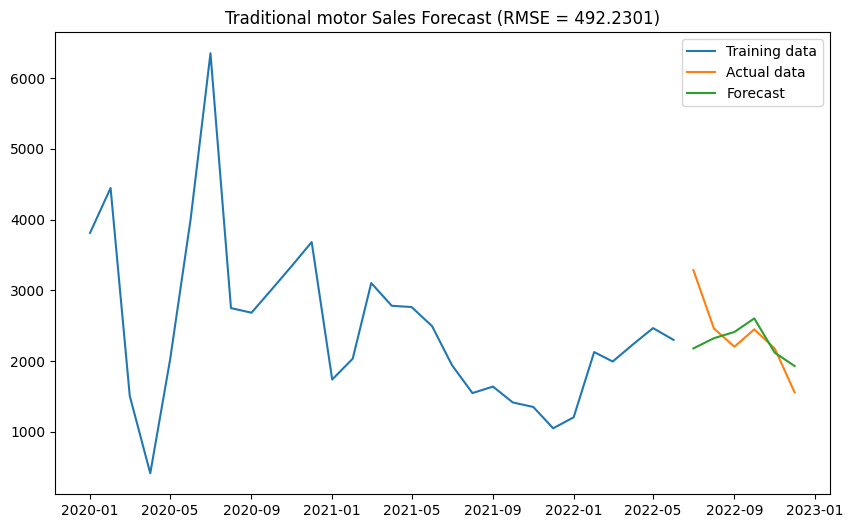

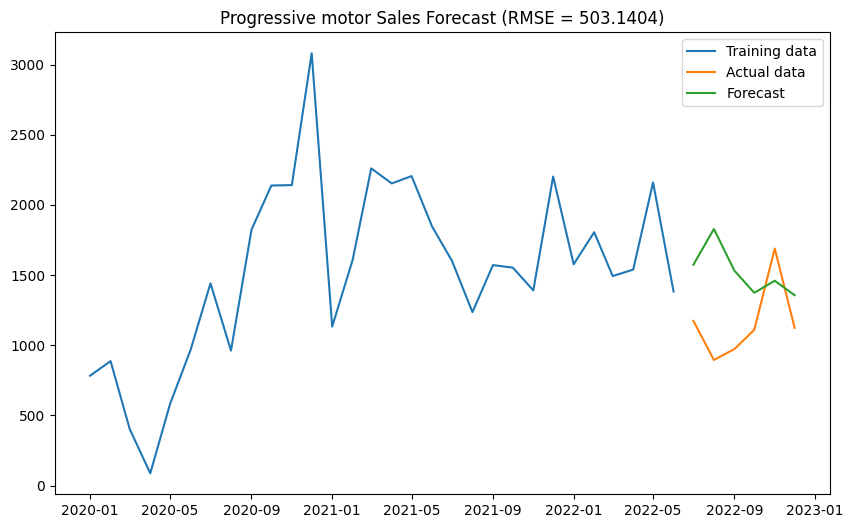

In [21]:
# Mostramos resultados en gráfico
train_df_t_plotting = train_df_t.copy()
test_df_t_plotting = test_df_t.copy()
train_df_p_plotting = train_df_p.copy()
test_df_p_plotting = test_df_p.copy()

train_df_t_plotting.index = train_df_t_plotting.index.to_timestamp()
test_df_t_plotting.index = test_df_t_plotting.index.to_timestamp()
train_df_p_plotting.index = train_df_p_plotting.index.to_timestamp()
test_df_p_plotting.index = test_df_p_plotting.index.to_timestamp()

forecast_rf_t_plotting = forecast_rf_t.copy()
forecast_rf_p_plotting = forecast_rf_p.copy()

forecast_rf_t_plotting.index = forecast_rf_t_plotting.index.to_timestamp()
forecast_rf_p_plotting.index = forecast_rf_p_plotting.index.to_timestamp()

plt.figure(figsize=(10, 6))
plt.plot(train_df_t_plotting, label='Training data')
plt.plot(test_df_t_plotting, label='Actual data')
plt.plot(forecast_rf_t_plotting, label='Forecast')
plt.title('Traditional motor Sales Forecast (RMSE = ' + str(round(rmse_rf_t, 4)) + ')')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_df_p_plotting, label='Training data')
plt.plot(test_df_p_plotting, label='Actual data')
plt.plot(forecast_rf_p_plotting, label='Forecast')
plt.title('Progressive motor Sales Forecast (RMSE = ' + str(round(rmse_rf_p, 4)) + ')')
plt.legend()
plt.show()

Las predicciones, pese a ser mejores en RMSE que las de SARIMA, no captan la tendencia de las ventas, algo a lo que SARIMA se aproxima mejor. Esto se debe a que, en general, las predicciones del modelo Random Forest son predicciones
seguras que no se alejan mucho de la media de las ventas recientes.

## Predicciones futuras

Utilizaremos los modelos SARIMA y Random Forest para predecir los 3 próximos meses.

Para Random Forest, tomaremos como predictoras las medias de los últimos meses con datos disponibles: enero tomará la media de octubre, noviembre y diciembre, febrero tomará la media de noviembre y diciembre y marzo tomará los valores de diciembre.

In [22]:
# Obtenemos los datos de todos los meses en una única serie para SARIMA
df_t_all = df[df['Hybrid'] == 'Traditional'].groupby('Date')['Hybrid'].count()
df_p_all = df[df['Hybrid'] == 'Progressive'].groupby('Date')['Hybrid'].count()

df_t_all.head()

Date
2020-01    3811
2020-02    4445
2020-03    1507
2020-04     414
2020-05    2022
Freq: M, Name: Hybrid, dtype: int64

In [23]:
# Preparamos los datos para predicciones de Random Forest

# Para las predicciones, creamos el dataframe con los tres meses como índice y las columnas de las variables predictoras
pred_index = pd.to_datetime(['2023-01', '2023-02', '2023-03']).to_period('M')
X_df_t = pd.DataFrame(index=pred_index, columns=df_dummies_t_mean.columns)
X_df_p = pd.DataFrame(index=pred_index, columns=df_dummies_t_mean.columns)

# Asignamos a enero la media de octubre, noviembre y diciembre
X_df_t.loc['2023-01'] = df_dummies_t.loc['2022-10':'2022-12'].mean()
X_df_p.loc['2023-01'] = df_dummies_p.loc['2022-10':'2022-12'].mean()  

# Asignamos a febrero la media de noviembre y diciembre
X_df_t.loc['2023-02'] = df_dummies_t.loc['2022-11':'2022-12'].mean()
X_df_p.loc['2023-02'] = df_dummies_p.loc['2022-11':'2022-12'].mean()

# Asignamos a marzo los valores de diciembre
X_df_t.loc['2023-03'] = df_dummies_t.loc['2022-12']
X_df_p.loc['2023-03'] = df_dummies_p.loc['2022-12']

X_df_t.head()

Channel_FLEET Channel_RAC Channel_RETAIL  Vehicle_Car  \
2023-01   1361.666667   57.666667     640.666667  1165.333333   
2023-02        1261.0        46.5          558.5       1028.5   
2023-03          1079          34            443          797   

        Vehicle_Light Commercial Vehicle_Medium Commercial     Zone_N1  \
2023-01                    337.0                557.666667  210.666667   
2023-02                    313.0                     524.5       219.5   
2023-03                      266                       493         135   

            Zone_N2     Zone_N3 Zone_N4     Zone_N5 Zone_N6     Zone_N7  \
2023-01  534.666667  299.666667    37.0  545.666667   180.0  234.666667   
2023-02       485.0       211.0    28.5       523.5   163.5       230.5   
2023-03         280         186      38         548     110         255   

        Zone_Z1    Zone_Z2  
2023-01     0.0  17.666667  
2023-02     0.0        4.5  
2023-03       0          4

In [24]:
# Entrenamos los modelos con todos los datos
# SARIMA
print('Training SARIMA model...')
params = best_params['Traditional']
sarima_t = SARIMAX(df_t_all, order=params[:3], seasonal_order=params[3:])
pred_sarima_t = sarima_t.fit(maxiter=200, method='powell', disp=False).get_forecast(steps=3).predicted_mean
print('Prediction for Traditional:\n', pred_sarima_t, sep='')

params = best_params['Progressive']
sarima_p = SARIMAX(df_p_all, order=params[:3], seasonal_order=params[3:])
pred_sarima_p = sarima_p.fit(maxiter=200, method='powell', disp=False).get_forecast(steps=3).predicted_mean
print('Prediction for Progressive:\n', pred_sarima_p, sep='')

print()

# Random Forest
print('Training Random Forest model...')
params = best_params_rf['Traditional']
rf_t = RandomForestRegressor(n_estimators=params[0], max_depth=params[1], bootstrap=params[2], random_state=0)
rf_t.fit(df_dummies_t_mean, df_t_all.iloc[3:])
pred_rf_t = pd.Series(rf_t.predict(X_df_t), index=X_df_t.index)
print('Prediction for Traditional:\n', pred_rf_t, sep='')

params = best_params_rf['Progressive']
rf_p = RandomForestRegressor(n_estimators=params[0], max_depth=params[1], bootstrap=params[2], random_state=0)
rf_p.fit(df_dummies_p_mean, df_p_all.iloc[3:])
pred_rf_p = pd.Series(rf_p.predict(X_df_p), index=X_df_p.index)
print('Prediction for Progressive:\n', pred_rf_p, sep='')

Training SARIMA model...
Prediction for Traditional:
2023-01     502.413845
2023-02    1510.819715
2023-03    2370.745579
Freq: M, Name: predicted_mean, dtype: float64
Prediction for Progressive:
2023-01   -227.743432
2023-02    137.139408
2023-03    353.979939
Freq: M, Name: predicted_mean, dtype: float64

Training Random Forest model...
Prediction for Traditional:
2023-01    1705.581170
2023-02    1860.731257
2023-03    1906.918757
Freq: M, dtype: float64
Prediction for Progressive:
2023-01    1160.5
2023-02    1407.6
2023-03    1596.4
Freq: M, dtype: float64


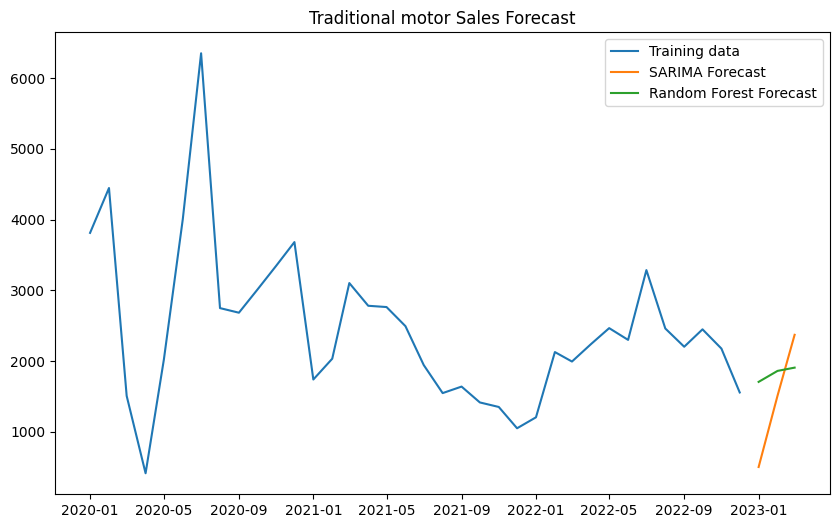

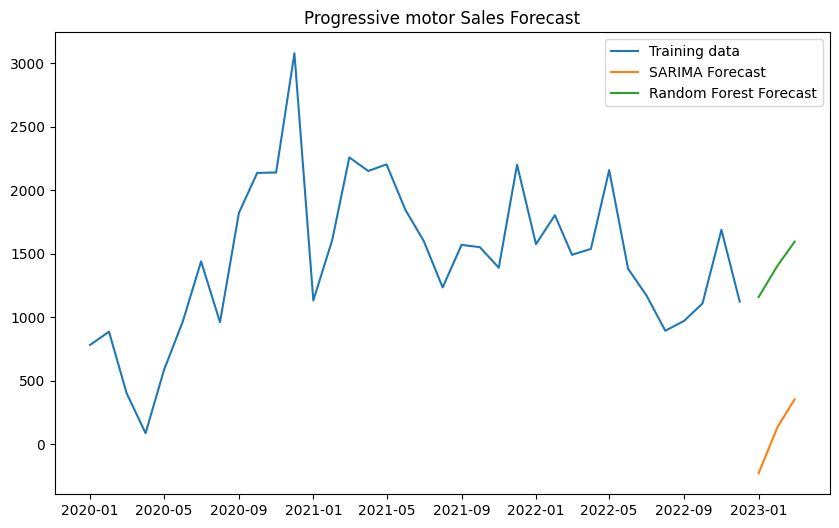

In [25]:
df_t_all_plotting = df_t_all.copy()
df_p_all_plotting = df_p_all.copy()

df_t_all_plotting.index = df_t_all_plotting.index.to_timestamp()
df_p_all_plotting.index = df_p_all_plotting.index.to_timestamp()
pred_sarima_t.index = pred_sarima_t.index.to_timestamp()
pred_sarima_p.index = pred_sarima_p.index.to_timestamp()
pred_rf_t.index = pred_rf_t.index.to_timestamp()
pred_rf_p.index = pred_rf_p.index.to_timestamp()

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(df_t_all_plotting, label='Training data')
plt.plot(pred_sarima_t, label='SARIMA Forecast')
plt.plot(pred_rf_t, label='Random Forest Forecast')
plt.title('Traditional motor Sales Forecast')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df_p_all_plotting, label='Training data')
plt.plot(pred_sarima_p, label='SARIMA Forecast')
plt.plot(pred_rf_p, label='Random Forest Forecast')
plt.title('Progressive motor Sales Forecast')
plt.legend()
plt.show()

SARIMA parece estar prediciendo muy mal, con valores incluso negativos para el mes de enero, esto puede deberse a que la serie temporal es corta (generalmente se requeriría de >5 años para utilizar SARIMA apropiadamente).

Random Forest parece, como hemos comentado antes, realizar predicciones bastante seguras y oscilantes en torno a la media.